### ANÁLISE E PREVISÃO DA ARRECADAÇÃO FEDERAL

Autor: GABRIEL RODRIGUES  MARCOLINI

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.
C:\Users\grmar\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\grmar\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\grmar\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\grmar\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
#Define função para calcular o MAPE - Mean Absolute Percentage Error
def mape(y_pred,y_true):

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
# fix random seed for reproducibility
np.random.seed(100)


In [4]:
#Define parâmetros iniciais
dataset_path = '.\\dataset\\CSV\\'
filename_input = 'arrecadacao-TOTAL-GERAL-2015-2020.csv'
indicadores = 'xgdvConsulta.csv'

#Faz a leitura dos datasets
#tb = tabela de Arrecadação Federal
#ie = tabela de indicadores econômicos
tb = pd.read_csv(dataset_path+filename_input) 
ie = pd.read_csv(dataset_path+indicadores,sep=';',decimal=',')

#Ajusta o campo DATA do dataframe ie
ie['DATA'] =  pd.to_datetime(ie['DATA'],format="%m/%Y") + pd.tseries.offsets.MonthEnd(0)
#Ajusta o campo DATA do dataframe tb
tb['DATA'] = pd.to_datetime(tb['DATA'],format="%Y/%m/%d")

#Unindo os dataframes tb + ie
left = tb.groupby([tb['DATA']]).sum()
right = ie
result = pd.merge(left,right,how='inner',on='DATA')

# Criando um novo DF para tratar os desvios de arrecadação (outliers) observados em 10/2016 e 04, 05 e 06/2020.
# Os valores serão substitudo pelo valor arrecadado no mesmo mês do ano anterior. 
#outliers = ['2016-10-31','2020-04-30','2020-05-31','2020-06-30']

result_n = result.copy()

result_n.loc[(result_n['DATA'] == '2016-10-31'),'VALOR'] = result_n.loc[(result_n['DATA'] == '2015-10-31'),'VALOR'].values
result_n.loc[(result_n['DATA'] == '2020-04-30'),'VALOR'] = result_n.loc[(result_n['DATA'] == '2019-04-30'),'VALOR'].values
result_n.loc[(result_n['DATA'] == '2020-05-31'),'VALOR'] = result_n.loc[(result_n['DATA'] == '2019-05-31'),'VALOR'].values
result_n.loc[(result_n['DATA'] == '2020-06-30'),'VALOR'] = result_n.loc[(result_n['DATA'] == '2019-06-30'),'VALOR'].values


# Ajustar parâmetros de plotagem
#plt.rcParams.keys()
plt.rcParams["text.color"] = 'Blue'
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["figure.figsize"] = [15, 7]
plt.rcParams["lines.linewidth"] = 2.0


In [5]:
# Definindo o dataset a ser analisado
df_real = result.groupby([result['DATA']]).sum()['VALOR']
df_normal = result_n.groupby([result_n['DATA']]).sum()['VALOR']
dataset = df_normal.values
raw_values = df_normal.values

## Modelo LSTM para Regressão

###### Referência e Créditos
https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [6]:
# Aplicar Diferenciação no dataset
dataset = np.array(pd.Series(dataset).diff())
dataset = np.delete(dataset,0)

In [7]:
# Normalizar o dataset
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = dataset.reshape(-1,1)
dataset = scaler.fit_transform(dataset)

In [8]:
# Criar a base de dados para aprendizado supervisionado
datasetX = np.array(dataset)
datasetY = np.array(pd.Series(dataset.reshape(-1)).shift(-1))

In [9]:
# Dividir o dataset em treino e teste 
trainX, testX = datasetX[0:-18], datasetX[-18:]
trainY, testY = datasetY[0:-18], datasetY[-18:]

In [10]:
# Remodelando dataset para entrada no modelo lSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [11]:
# Cria e treina o modelo LSTM
model = Sequential()
model.add(LSTM(4, input_shape=(1, 1) ))
model.add(Dense(1))
model.compile(loss='mse', metrics=['mape'], optimizer='adam')
model.fit(trainX, trainY, epochs=500, batch_size=1, verbose=0)

In [12]:
# Fazendo as previsões
testPredict = model.predict(testX)

#Ajustando os arrays
testPredict = np.delete(testPredict,testPredict.size-1)
testY = np.delete(testY, testY.size-1 )

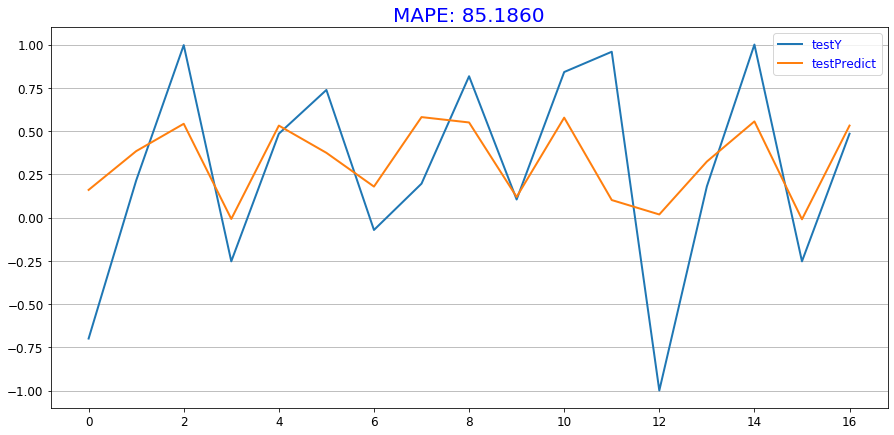

In [13]:
# Plota o valor observado vs previsto. 
plt.plot(testY, label='testY')
plt.plot(testPredict, label='testPredict')
plt.legend()
plt.title('MAPE: %.4f' % mape(testPredict, testY))
plt.grid(True,axis='y')
plt.show()

In [14]:
# Inverter a escala da previsão
testPredict_inv = scaler.inverse_transform(testPredict.reshape(-1,1))
testX_inv = scaler.inverse_transform(testX.reshape(-1,1))
testY_inv = scaler.inverse_transform(testY.reshape(-1,1))

In [15]:
## Inverter a diferença das previsões
test= raw_values[-testPredict.size:]
testPredict_cumsum = pd.Series(testPredict_inv.reshape(-1), copy = True).cumsum()
testPredict_add = pd.Series(test[0], index=testPredict_cumsum.index)
yhat = testPredict_cumsum.add(testPredict_add,fill_value=0)

In [29]:
# Define o campo DATA como indice das séries
test = pd.Series(test, index=result['DATA'][-yhat.size:])
yhat.index = result['DATA'][-yhat.size:]

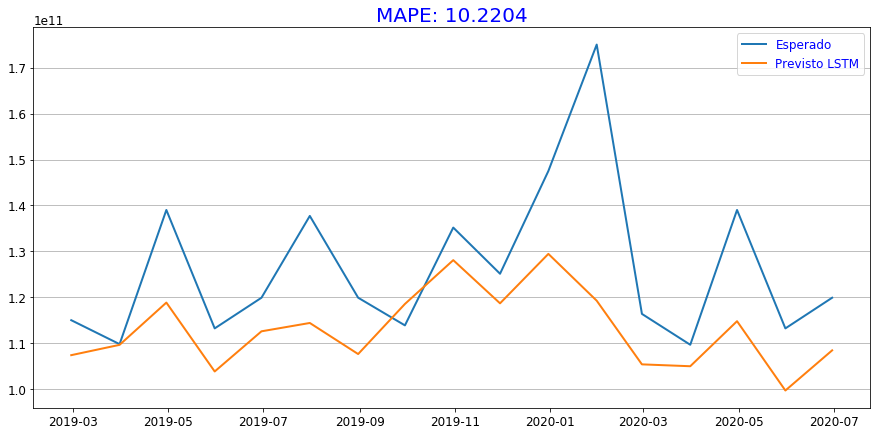

In [34]:
# Plota o valor observado vs previsto. 
plt.plot(test, label='Esperado')
plt.plot(yhat, label='Previsto LSTM')
plt.legend()
plt.title('MAPE: %.4f' % mape(yhat, test))
plt.grid(True,axis='y')
plt.show()

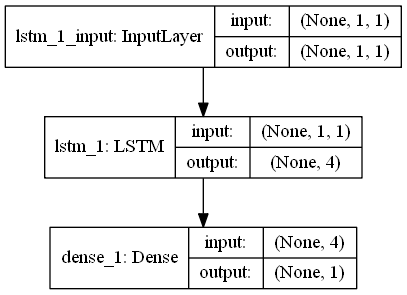

In [17]:
plot_model(model, show_shapes=True)

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
